# Cell 1: 노트북 개요 및 환경 설정

## 01_carla_setup.ipynb - CARLA 설치 확인 및 기본 테스트

이 노트북에서는 CARLA 시뮬레이터 연결 및 기본 기능을 테스트합니다.

### 테스트 항목
1. CARLA 서버 연결
2. 월드/맵 정보 확인
3. 차량 스폰
4. 카메라 센서 부착
5. Autopilot 주행
6. 스크린샷 캡처

### 사전 요구사항
- CARLA 0.9.15 설치 및 서버 실행
- `pip install carla==0.9.15`

In [11]:
# Cell 1: 라이브러리 임포트 및 설정

import sys
import os
import time
import logging
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display, clear_output

# 프로젝트 루트를 path에 추가
PROJECT_ROOT = Path().absolute().parent
sys.path.insert(0, str(PROJECT_ROOT))

# 로깅 설정
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# CARLA 임포트 테스트
try:
    import carla
    print(f"✅ CARLA 패키지 임포트 성공 (버전 확인 필요)")
except ImportError as e:
    print(f"❌ CARLA 패키지 임포트 실패: {e}")
    print("\n설치 방법:")
    print("pip install carla==0.9.15")
    print("\n또는 CARLA 설치 디렉토리에서:")
    print("pip install <CARLA_ROOT>/PythonAPI/carla/dist/carla-0.9.15-cp38-cp38-win_amd64.whl")

✅ CARLA 패키지 임포트 성공 (버전 확인 필요)


In [12]:
# Cell 2: CARLA 서버 연결

# 연결 설정
CARLA_HOST = 'localhost'
CARLA_PORT = 2000
TIMEOUT = 10.0

def connect_to_carla(host=CARLA_HOST, port=CARLA_PORT, timeout=TIMEOUT):
    """
    CARLA 서버에 연결
    
    Returns:
        tuple: (client, world) 또는 실패 시 (None, None)
    """
    try:
        print(f"CARLA 서버 연결 시도: {host}:{port}")
        client = carla.Client(host, port)
        client.set_timeout(timeout)
        
        # 월드 가져오기
        world = client.get_world()
        
        print(f"✅ 연결 성공!")
        return client, world
        
    except Exception as e:
        print(f"❌ 연결 실패: {e}")
        print("\n확인 사항:")
        print("1. CARLA 서버가 실행 중인지 확인")
        print("2. CarlaUE4.exe 실행")
        print("3. 방화벽 설정 확인")
        return None, None

# 연결 시도
client, world = connect_to_carla()

if world is not None:
    print(f"\n서버 버전: {client.get_server_version()}")
    print(f"클라이언트 버전: {client.get_client_version()}")

CARLA 서버 연결 시도: localhost:2000
✅ 연결 성공!

서버 버전: 0.9.16
클라이언트 버전: 0.9.16


In [13]:
# Cell 3: 월드/맵 정보 확인

if world is not None:
    # 현재 맵 정보
    current_map = world.get_map()
    print(f"현재 맵: {current_map.name}")
    
    # 사용 가능한 맵 목록
    available_maps = client.get_available_maps()
    print(f"\n사용 가능한 맵 ({len(available_maps)}개):")
    for m in available_maps:
        print(f"  - {m}")
    
    # 날씨 정보
    weather = world.get_weather()
    print(f"\n현재 날씨:")
    print(f"  - 구름: {weather.cloudiness}%")
    print(f"  - 강수량: {weather.precipitation}%")
    print(f"  - 태양 고도: {weather.sun_altitude_angle}°")
    
    # 스폰 포인트 확인
    spawn_points = current_map.get_spawn_points()
    print(f"\n스폰 포인트 개수: {len(spawn_points)}")
else:
    print("❌ CARLA 서버에 연결되지 않았습니다.")

현재 맵: Carla/Maps/Town10HD_Opt

사용 가능한 맵 (13개):
  - Town01
  - Town01_Opt
  - Town02
  - Town02_Opt
  - Town03
  - Town03_Opt
  - Town04
  - Town04_Opt
  - Town05
  - Town05_Opt
  - Town10HD
  - Town10HD_Opt
  - AnnotationColorLandscape

현재 날씨:
  - 구름: 20.0%
  - 강수량: 0.0%
  - 태양 고도: 45.0°

스폰 포인트 개수: 155


In [14]:
# Cell 4: 차량 스폰 테스트

vehicle = None

if world is not None:
    # 블루프린트 라이브러리
    blueprint_library = world.get_blueprint_library()
    
    # 차량 블루프린트 목록
    vehicle_blueprints = blueprint_library.filter('vehicle.*')
    print(f"사용 가능한 차량: {len(vehicle_blueprints)}종")
    
    # Tesla Model 3 선택 (없으면 첫 번째 차량)
    vehicle_bp = blueprint_library.find('vehicle.tesla.model3')
    if vehicle_bp is None:
        vehicle_bp = vehicle_blueprints[0]
    
    print(f"선택된 차량: {vehicle_bp.id}")
    
    # 랜덤 스폰 포인트 선택
    spawn_points = world.get_map().get_spawn_points()
    spawn_point = np.random.choice(spawn_points)
    
    # 차량 스폰
    try:
        vehicle = world.spawn_actor(vehicle_bp, spawn_point)
        print(f"✅ 차량 스폰 성공!")
        print(f"  - ID: {vehicle.id}")
        print(f"  - 위치: {spawn_point.location}")
    except Exception as e:
        print(f"❌ 차량 스폰 실패: {e}")
else:
    print("❌ CARLA 서버에 연결되지 않았습니다.")

사용 가능한 차량: 41종
선택된 차량: vehicle.tesla.model3
✅ 차량 스폰 성공!
  - ID: 30
  - 위치: Location(x=98.800659, y=82.890846, z=0.600000)


In [15]:
# Cell 5: 카메라 센서 부착

camera = None
captured_image = None

def process_image(image):
    """카메라 이미지 콜백 함수"""
    global captured_image
    # BGRA -> RGB 변환
    array = np.frombuffer(image.raw_data, dtype=np.uint8)
    array = array.reshape((image.height, image.width, 4))
    array = array[:, :, :3]  # BGRA -> BGR
    array = array[:, :, ::-1]  # BGR -> RGB
    captured_image = array

if vehicle is not None:
    # 카메라 블루프린트
    camera_bp = blueprint_library.find('sensor.camera.rgb')
    
    # 카메라 속성 설정
    camera_bp.set_attribute('image_size_x', '800')
    camera_bp.set_attribute('image_size_y', '600')
    camera_bp.set_attribute('fov', '100')
    
    # 카메라 부착 위치 (차량 앞쪽 상단)
    camera_transform = carla.Transform(
        carla.Location(x=1.5, z=2.4),
        carla.Rotation(pitch=-10)
    )
    
    # 카메라 스폰 및 부착
    try:
        camera = world.spawn_actor(camera_bp, camera_transform, attach_to=vehicle)
        camera.listen(process_image)
        print(f"✅ 카메라 부착 성공!")
        print(f"  - 해상도: 800x600")
        print(f"  - FOV: 100°")
    except Exception as e:
        print(f"❌ 카메라 부착 실패: {e}")
else:
    print("❌ 차량이 스폰되지 않았습니다.")

✅ 카메라 부착 성공!
  - 해상도: 800x600
  - FOV: 100°


In [16]:
# Cell 6: Autopilot 주행 테스트

if vehicle is not None:
    # Autopilot 활성화
    vehicle.set_autopilot(True)
    print("✅ Autopilot 활성화!")
    print("\n5초간 주행 후 이미지 캡처...")
    
    # 잠시 주행
    for i in range(50):
        world.tick()  # 동기 모드가 아닐 경우 sleep 사용
        time.sleep(0.1)
        
        # 속도 출력
        velocity = vehicle.get_velocity()
        speed_mps = np.sqrt(velocity.x**2 + velocity.y**2 + velocity.z**2)
        speed_kmh = speed_mps * 3.6
        
        if i % 10 == 0:
            print(f"  {i/10:.0f}초: 속도 {speed_kmh:.1f} km/h")
    
    print("\n주행 완료!")
else:
    print("❌ 차량이 스폰되지 않았습니다.")

✅ Autopilot 활성화!

5초간 주행 후 이미지 캡처...
  0초: 속도 7.1 km/h
  1초: 속도 19.0 km/h
  2초: 속도 28.4 km/h
  3초: 속도 28.9 km/h
  4초: 속도 29.1 km/h

주행 완료!


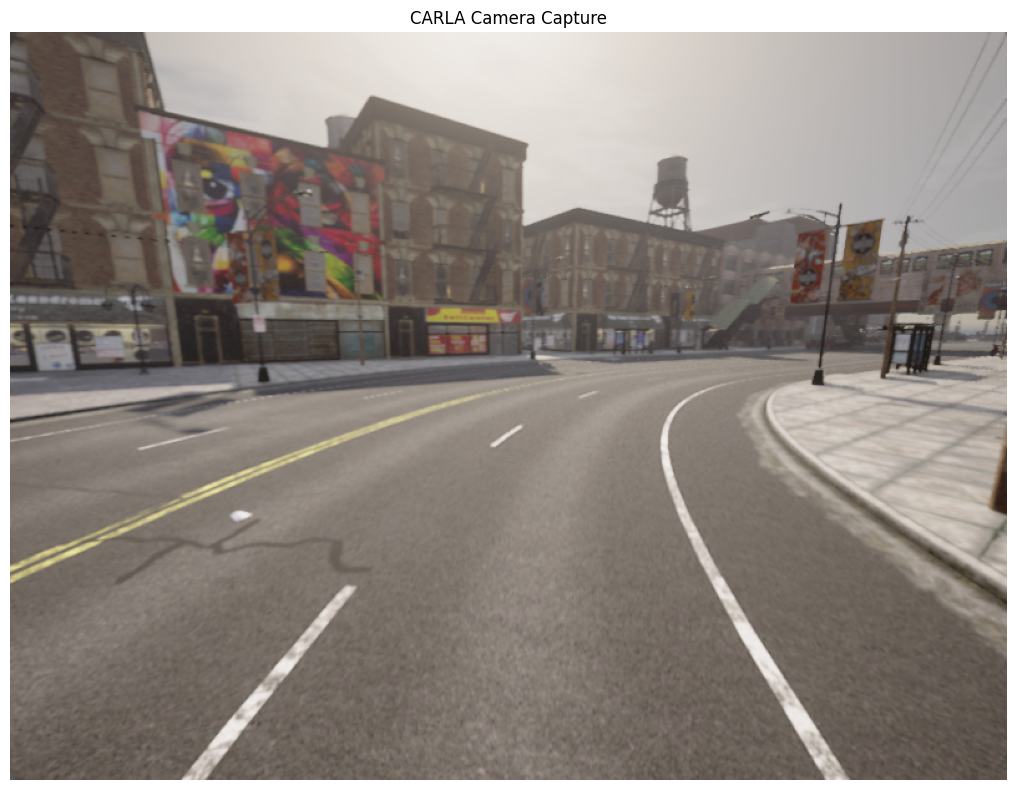

이미지 크기: (600, 800, 3)


In [17]:
# Cell 7: 캡처된 이미지 표시

if captured_image is not None:
    plt.figure(figsize=(12, 8))
    plt.imshow(captured_image)
    plt.title('CARLA Camera Capture')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"이미지 크기: {captured_image.shape}")
else:
    print("❌ 캡처된 이미지가 없습니다.")
    print("카메라가 정상적으로 부착되었는지 확인하세요.")

In [18]:
# Cell 8: 이미지 저장

import cv2

if captured_image is not None:
    # 저장 디렉토리 생성
    save_dir = PROJECT_ROOT / 'dataset' / 'carla_test'
    save_dir.mkdir(parents=True, exist_ok=True)
    
    # 이미지 저장
    save_path = save_dir / 'test_capture.jpg'
    cv2.imwrite(str(save_path), cv2.cvtColor(captured_image, cv2.COLOR_RGB2BGR))
    
    print(f"✅ 이미지 저장 완료: {save_path}")
else:
    print("❌ 저장할 이미지가 없습니다.")

✅ 이미지 저장 완료: c:\git\automotive\dataset\carla_test\test_capture.jpg


In [19]:
# Cell 9: 차량 상태 정보 확인

if vehicle is not None:
    # 위치
    transform = vehicle.get_transform()
    print("차량 상태 정보:")
    print(f"  위치: x={transform.location.x:.2f}, y={transform.location.y:.2f}, z={transform.location.z:.2f}")
    print(f"  방향: pitch={transform.rotation.pitch:.2f}, yaw={transform.rotation.yaw:.2f}, roll={transform.rotation.roll:.2f}")
    
    # 속도
    velocity = vehicle.get_velocity()
    speed_mps = np.sqrt(velocity.x**2 + velocity.y**2 + velocity.z**2)
    print(f"  속도: {speed_mps:.2f} m/s ({speed_mps * 3.6:.1f} km/h)")
    
    # 신호등 상태
    if vehicle.is_at_traffic_light():
        traffic_light = vehicle.get_traffic_light()
        state = traffic_light.get_state()
        print(f"  신호등: {state}")
    else:
        print("  신호등: 없음")
    
    # 컨트롤 상태
    control = vehicle.get_control()
    print(f"  조향: {control.steer:.3f}")
    print(f"  가속: {control.throttle:.3f}")
    print(f"  제동: {control.brake:.3f}")
else:
    print("❌ 차량이 스폰되지 않았습니다.")

차량 상태 정보:
  위치: x=89.37, y=118.46, z=0.00
  방향: pitch=-0.00, yaw=126.99, roll=-0.07
  속도: 8.07 m/s (29.1 km/h)
  신호등: 없음
  조향: 0.093
  가속: 0.355
  제동: 0.000


In [20]:
# Cell 10: 정리 (액터 삭제)

actors_to_destroy = []

if camera is not None:
    camera.stop()
    actors_to_destroy.append(camera)

if vehicle is not None:
    vehicle.set_autopilot(False)
    actors_to_destroy.append(vehicle)

# 액터 삭제
for actor in actors_to_destroy:
    try:
        actor.destroy()
    except Exception as e:
        print(f"액터 삭제 실패: {e}")

print(f"✅ {len(actors_to_destroy)}개 액터 정리 완료")
print("\n=== CARLA 설정 테스트 완료 ===")
print("\n다음 단계:")
print("1. 02_data_collection.ipynb - 데이터 수집 시작")

✅ 2개 액터 정리 완료

=== CARLA 설정 테스트 완료 ===

다음 단계:
1. 02_data_collection.ipynb - 데이터 수집 시작


## 테스트 결과 요약

| 항목 | 상태 |
|------|------|
| CARLA 패키지 | ✅/❌ |
| 서버 연결 | ✅/❌ |
| 차량 스폰 | ✅/❌ |
| 카메라 부착 | ✅/❌ |
| Autopilot | ✅/❌ |
| 이미지 캡처 | ✅/❌ |

문제가 있다면:
1. CARLA 서버가 실행 중인지 확인
2. 버전 호환성 확인 (0.9.15 권장)
3. GPU 드라이버 업데이트